# LSTM 모델 적용

### 패키지 import

In [1]:
import keras
import warnings

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import os
os.chdir(r'C:\Users\joyh1\Desktop\DSC\DSC_음메\cow_data\final_data')

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


### 데이터 불러오기 

In [3]:
data = pd.read_excel('축산물.xlsx')

In [4]:
weather = pd.read_pickle('관측정보.pkl')

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


def check_stationarity(y, lags_plots=48, figsize=(16,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('한우가격_미래값(y값)')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(np.sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -3.4150
p-value                          0.0105
Lags Used                        9.0000
Number of Observations Used    975.0000
Critical Value (1%)             -3.4371
Critical Value (5%)             -2.8645
Critical Value (10%)            -2.5684
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


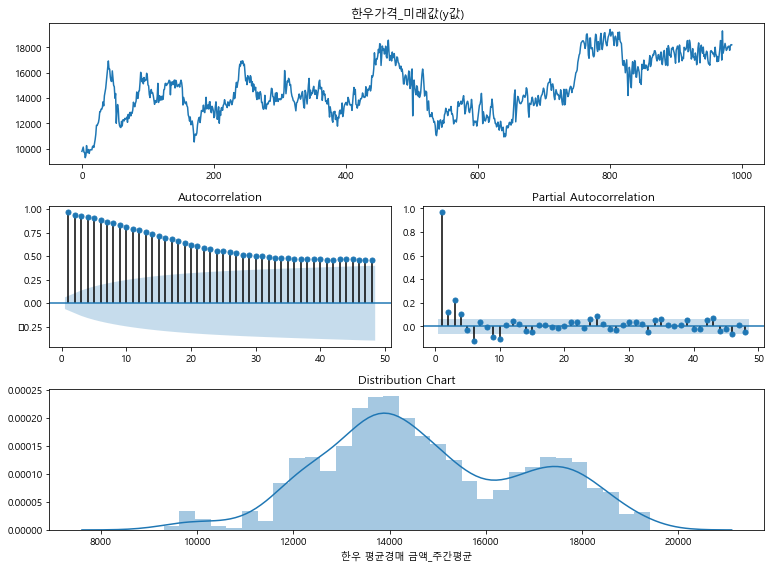

In [6]:
warnings.filterwarnings(action='ignore')

check_stationarity(data['한우 평균경매 금액_주간평균'])

Results of Dickey-Fuller Test:
Test Statistic                  -8.9934
p-value                          0.0000
Lags Used                       10.0000
Number of Observations Used    973.0000
Critical Value (1%)             -3.4371
Critical Value (5%)             -2.8645
Critical Value (10%)            -2.5684
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


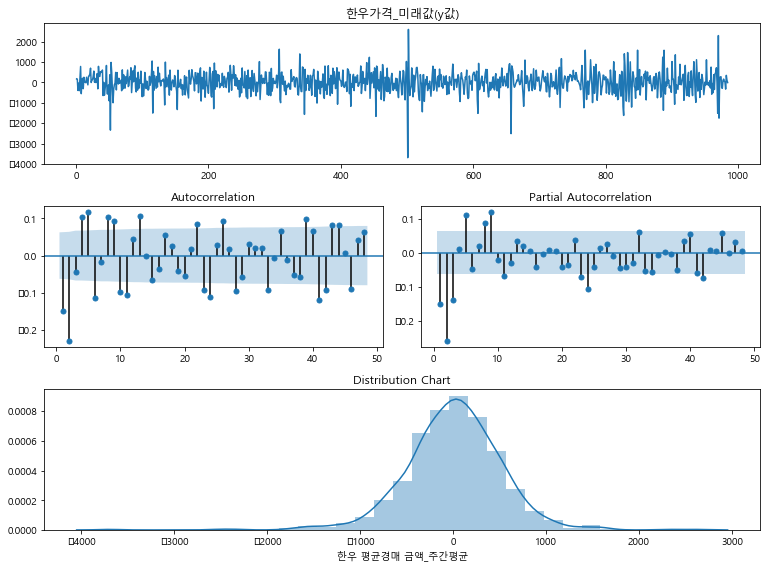

In [7]:
warnings.filterwarnings(action='ignore')

check_stationarity(data['한우 평균경매 금액_주간평균'].diff().dropna())

### 불필요한 데이터 삭제 

In [8]:
data2 = pd.merge(data,weather,on='주간날짜')

In [9]:
del data2['Unnamed: 0']
del data2['year']
del data2['month']
del data2['날짜']

In [10]:
data2 = data2.reset_index()
del data2['index']

In [11]:
data2['y_value'] = 1
for i in range(0,(len(data2)-1)):
    data2['y_value'][i] = data2['한우 평균경매 금액_주간평균'][i+1]

In [12]:
data2['y_value'] = data2['y_value'].astype('float')

In [13]:
data2

,주간날짜,한우 평균경매 금액_주간평균,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_value
0,2001-02-11,9798.00,-0.500000,-3.800000,3.814286,0.400000,20.857143,39.085714,9973.0
1,2001-02-18,9973.20,6.128571,1.685714,10.914286,4.057143,39.428571,60.328571,10136.0
2,2001-02-25,10136.50,5.042857,-0.257143,11.171429,4.857143,29.571429,55.385714,9740.0
3,2001-03-04,9740.80,1.214286,-2.728571,5.585714,2.885714,26.000000,44.557143,9707.0
4,2001-03-11,9707.20,5.828571,0.328571,11.642857,6.414286,29.571429,52.171429,9300.0
...,...,...,...,...,...,...,...,...,...
929,2018-12-02,17552.00,4.628571,0.985714,8.828571,4.828571,35.285714,56.528571,17273.0
930,2018-12-09,17273.00,0.057143,-4.071429,4.728571,-0.600000,23.142857,41.157143,16625.0
931,2018-12-16,16625.60,6.271429,3.200000,10.185714,3.042857,23.142857,39.885714,16929.0
932,2018-12-23,16929.00,0.485714,-3.428571,5.742857,0.314286,12.857143,26.857143,17944.0


In [14]:
data2 = data2.dropna()

In [15]:
data2['lag1_price'] = data2['y_value'].shift(1)
data2['lag2_price'] = data2['y_value'].shift(2)
data2['lag3_price'] = data2['y_value'].shift(3)
data2['lag5_price'] = data2['y_value'].shift(5)
data2['lag10_price'] = data2['y_value'].shift(10)
data2['lag15_price'] = data2['y_value'].shift(15)

In [16]:
del data2['한우 평균경매 금액_주간평균']

In [17]:
data2 = data2.dropna()

### 시각화를 위해 주간날짜 index로 변환 

In [18]:
data2 = data2.set_index('주간날짜')

In [19]:
data2.isnull().sum()

평균기온           0
최저기온           0
최고기온           0
평균지면온도         0
최소상대습도(%)      0
평균상대습도(%)      0
y_value        0
lag1_price     0
lag2_price     0
lag3_price     0
lag5_price     0
lag10_price    0
lag15_price    0
dtype: int64

### 시각화

In [478]:
'''data2 = data2.drop(['year','month','날짜','Unnamed: 0'],axis=1)'''

"data2 = data2.drop(['year','month','날짜','Unnamed: 0'],axis=1)"

In [20]:
data2 = data2.reset_index()

In [21]:
985*0.7

689.5

In [22]:
train = data2.iloc[:690,:]
test = data2.iloc[690:]

In [23]:
test

,주간날짜,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_value,lag1_price,lag2_price,lag3_price,lag5_price,lag10_price,lag15_price
690,2014-08-24,22.142857,19.571429,25.128571,24.928571,59.857143,75.885714,15222.0,15158.0,14888.0,14316.0,13945.0,14271.0,13920.0
691,2014-08-31,22.542857,18.985714,26.400000,24.142857,51.000000,67.528571,15245.0,15222.0,15158.0,14888.0,14011.0,14519.0,13579.0
692,2014-09-07,22.014286,18.271429,26.271429,24.528571,53.142857,71.228571,15522.0,15245.0,15222.0,15158.0,14316.0,14780.0,13434.0
693,2014-09-14,20.357143,16.742857,25.157143,23.142857,43.285714,66.985714,15075.0,15522.0,15245.0,15222.0,14888.0,14629.0,14036.0
694,2014-09-21,19.514286,15.642857,23.671429,21.357143,51.285714,71.928571,14610.0,15075.0,15522.0,15245.0,15158.0,14211.0,14212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2018-11-25,8.228571,3.814286,13.042857,5.028571,22.714286,40.971429,17552.0,16987.0,17225.0,17204.0,17406.0,17726.0,17787.0
912,2018-12-02,4.628571,0.985714,8.828571,4.828571,35.285714,56.528571,17273.0,17552.0,16987.0,17225.0,17896.0,18562.0,17877.0
913,2018-12-09,0.057143,-4.071429,4.728571,-0.600000,23.142857,41.157143,16625.0,17273.0,17552.0,16987.0,17204.0,18354.0,18128.0
914,2018-12-16,6.271429,3.200000,10.185714,3.042857,23.142857,39.885714,16929.0,16625.0,17273.0,17552.0,17225.0,17710.0,18531.0


In [24]:
data.dtypes

Unnamed: 0                  int64
주간날짜               datetime64[ns]
한우 평균경매 금액_주간평균           float64
year                        int64
month                       int64
날짜                         object
dtype: object

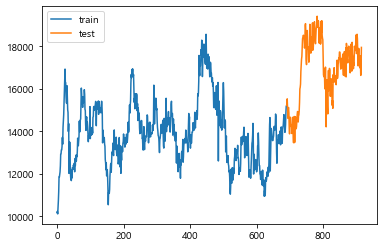

In [25]:
ax = train['y_value'].plot()
test['y_value'].plot(ax=ax)
plt.legend(['train', 'test'])

### 정규화

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_x = scaler.fit_transform(train.drop(['주간날짜','y_value'],axis=1))
test_x = scaler.transform(test.drop(['주간날짜','y_value'],axis=1))
train_y= scaler.fit_transform(pd.DataFrame(train['y_value']))
test_y= scaler.transform(pd.DataFrame(test['y_value']))

In [27]:
feature_names = data2.drop(['주간날짜','y_value'],axis=1).columns
feature_names = [list(i) for i in feature_names]
feature_names = [''.join(i) for i in feature_names]
print(feature_names)

['평균기온', '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'lag1_price', 'lag2_price', 'lag3_price', 'lag5_price', 'lag10_price', 'lag15_price']


In [28]:
pd.options.display.max_columns = 30
data2.head()

,주간날짜,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_value,lag1_price,lag2_price,lag3_price,lag5_price,lag10_price,lag15_price
0,2001-05-27,21.514286,15.500000,28.100000,22.314286,22.857143,48.614286,10167.0,9914.0,9931.0,9925.0,9638.0,9470.0,9973.0
1,2001-06-03,23.657143,19.871429,28.928571,26.314286,40.714286,57.714286,10228.0,10167.0,9914.0,9931.0,9891.0,10252.0,10136.0
2,2001-06-10,19.285714,16.014286,23.300000,22.228571,55.571429,73.185714,10107.0,10228.0,10167.0,9914.0,9925.0,9698.0,9740.0
3,2001-06-17,20.957143,18.157143,24.542857,22.585714,60.142857,76.857143,10408.0,10107.0,10228.0,10167.0,9931.0,9742.0,9707.0
4,2001-06-24,24.628571,21.657143,29.185714,25.414286,48.142857,65.071429,10722.0,10408.0,10107.0,10228.0,9914.0,9946.0,9300.0


In [464]:
data2.to_pickle('prw_0604.pkl')

### feature selection 2

In [39]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
from sklearn import datasets, linear_model

# Feature Selection하기 전에 문제해결에 맞는 모델 선정
regression = linear_model.LinearRegression()
# 선정된 모델에 맞는 feature selection 수행
efs = efs(regression,
         min_features=3,
         max_features=12,
         scoring='r2',
         cv=5)

efs.fit(train_x, train_y,custom_feature_names=feature_names)
print(efs.best_idx_)

Features: 4017/4017

(0, 1, 6, 8, 9, 10)


In [40]:
features = list(efs.best_feature_names_)
print(features)

['평균기온', '최저기온', 'lag1_price', 'lag3_price', 'lag5_price', 'lag10_price']


### feature_selection 1

In [466]:
# Sequential Feature Seletor
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn import datasets, linear_model

clf = linear_model.LinearRegression()

# Build step forward feature selection                              # cv = cross_validation
sfs1 = sfs(clf,k_features = 5,forward=True,floating=False, scoring='r2',cv=5)

# Perform SFFS
sfs1 = sfs1.fit(train_x, train_y,custom_feature_names=feature_names)


In [467]:
sfs1.k_feature_idx_

(4, 6, 8, 9, 10)

In [468]:
features = list(sfs1.k_feature_names_)

In [469]:
features

['최소상대습도(%)', 'lag1_price', 'lag3_price', 'lag5_price', 'lag10_price']

---

In [42]:
train_x = scaler.fit_transform(train[features])
test_x = scaler.transform(test[features])
train_y= scaler.fit_transform(pd.DataFrame(train['y_value']))
test_y= scaler.transform(pd.DataFrame(test['y_value']))

In [43]:
train_X = train_x.reshape(train_x.shape[0], 1, train_x.shape[1])
test_X = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(690, 1, 6) (690, 1) (226, 1, 6) (226, 1)


In [472]:
'''model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, 1, 5), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(train_X, train_y, epochs=500, batch_size=20,verbose=1)

y_hat = model.predict(test_X, batch_size=1)
'''

"model = Sequential()\nmodel.add(LSTM(32, batch_input_shape=(1, 1, 5), stateful=True))\nmodel.add(Dropout(0.3))\nmodel.add(Dense(1))\n\nmodel.compile(loss='mse', optimizer='adam')\nmodel.fit(train_X, train_y, epochs=500, batch_size=20,verbose=1)\n\ny_hat = model.predict(test_X, batch_size=1)\n"

In [44]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.

xInput = Input(batch_shape=(None, train_X.shape[1], train_X.shape[2]))
xLstm_1 = LSTM(10, return_sequences = True)(xInput)
xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
xOutput = Dense(1)(xLstm_2)

model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer='adam')

# 학습
model.fit(train_X, train_y, epochs=500, batch_size=20,verbose=1)

# 예측
y_hat = model.predict(test_X, batch_size=1)


Epoch 1/500
690/690 [==============================] - 3s 4ms/step - loss: 0.1865
Epoch 2/500
690/690 [==============================] - 0s 333us/step - loss: 0.0795
Epoch 3/500
690/690 [==============================] - 0s 258us/step - loss: 0.0257
Epoch 4/500
690/690 [==============================] - 0s 327us/step - loss: 0.0204
Epoch 5/500
690/690 [==============================] - 0s 307us/step - loss: 0.0163
Epoch 6/500
690/690 [==============================] - 0s 285us/step - loss: 0.0123
Epoch 7/500
690/690 [==============================] - 0s 354us/step - loss: 0.0090
Epoch 8/500
690/690 [==============================] - 0s 320us/step - loss: 0.0066
Epoch 9/500
690/690 [==============================] - 0s 288us/step - loss: 0.0056
Epoch 10/500
690/690 [==============================] - 0s 292us/step - loss: 0.0050
Epoch 11/500
690/690 [==============================] - 0s 341us/step - loss: 0.0047
Epoch 12/500
690/690 [==============================] - 0s 383us/step - loss

690/690 [==============================] - 0s 379us/step - loss: 0.0032
Epoch 193/500
690/690 [==============================] - 0s 357us/step - loss: 0.0032
Epoch 194/500
690/690 [==============================] - 0s 297us/step - loss: 0.0032
Epoch 195/500
690/690 [==============================] - 0s 353us/step - loss: 0.0032
Epoch 196/500
690/690 [==============================] - 0s 343us/step - loss: 0.0032
Epoch 197/500
690/690 [==============================] - 0s 298us/step - loss: 0.0031
Epoch 198/500
690/690 [==============================] - 0s 425us/step - loss: 0.0032
Epoch 199/500
690/690 [==============================] - 0s 356us/step - loss: 0.0033
Epoch 200/500
690/690 [==============================] - 0s 279us/step - loss: 0.0032
Epoch 201/500
690/690 [==============================] - 0s 213us/step - loss: 0.0032
Epoch 202/500
690/690 [==============================] - 0s 210us/step - loss: 0.0032
Epoch 203/500
690/690 [==============================] - 0s 215us/st

690/690 [==============================] - 0s 263us/step - loss: 0.0032
Epoch 288/500
690/690 [==============================] - 0s 298us/step - loss: 0.0032
Epoch 289/500
690/690 [==============================] - 0s 226us/step - loss: 0.0032
Epoch 290/500
690/690 [==============================] - 0s 312us/step - loss: 0.0032
Epoch 291/500
690/690 [==============================] - 0s 338us/step - loss: 0.0032
Epoch 292/500
690/690 [==============================] - 0s 325us/step - loss: 0.0033
Epoch 293/500
690/690 [==============================] - 0s 284us/step - loss: 0.0033
Epoch 294/500
690/690 [==============================] - 0s 281us/step - loss: 0.0032
Epoch 295/500
690/690 [==============================] - 0s 271us/step - loss: 0.0032
Epoch 296/500
690/690 [==============================] - 0s 288us/step - loss: 0.0033
Epoch 297/500
690/690 [==============================] - 0s 286us/step - loss: 0.0032
Epoch 298/500
690/690 [==============================] - 0s 333us/st

690/690 [==============================] - 0s 388us/step - loss: 0.0032
Epoch 478/500
690/690 [==============================] - 0s 289us/step - loss: 0.0031
Epoch 479/500
690/690 [==============================] - 0s 302us/step - loss: 0.0031
Epoch 480/500
690/690 [==============================] - 0s 281us/step - loss: 0.0031
Epoch 481/500
690/690 [==============================] - 0s 276us/step - loss: 0.0032
Epoch 482/500
690/690 [==============================] - 0s 289us/step - loss: 0.0032
Epoch 483/500
690/690 [==============================] - 0s 304us/step - loss: 0.0031
Epoch 484/500
690/690 [==============================] - 0s 322us/step - loss: 0.0032
Epoch 485/500
690/690 [==============================] - 0s 310us/step - loss: 0.0032
Epoch 486/500
690/690 [==============================] - 0s 306us/step - loss: 0.0031
Epoch 487/500
690/690 [==============================] - 0s 369us/step - loss: 0.0032
Epoch 488/500
690/690 [==============================] - 0s 478us/st

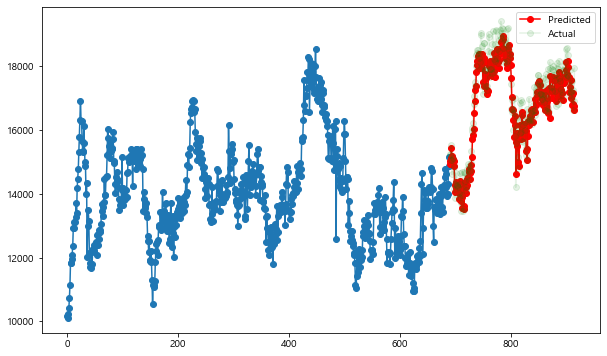

In [45]:
a_axis = np.arange(0, len(train_y))
b_axis = np.arange(len(train_y), len(train_y) + len(y_hat))

y_hat = scaler.inverse_transform(y_hat)
train_y = scaler.inverse_transform(train_y)
test_y = scaler.inverse_transform(test_y)

plt.figure(figsize=(10,6))
plt.plot(a_axis, train_y.reshape(690,), 'o-')
plt.plot(b_axis, y_hat.reshape(226,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, test_y.reshape(226,), 'o-', color='green', alpha=0.1, label='Actual')
plt.legend()
plt.show()


In [46]:
y_hat_train = model.predict(train_X, batch_size=1)
y_hat_train = scaler.inverse_transform(y_hat_train)

In [47]:
# feature selection 2에 대한 결과
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(train_y,y_hat_train))
print(mean_absolute_percentage_error(test_y,y_hat))

import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(train_y,y_hat_train))
print('TrainScore:%.df RMSE'%(trainScore))
testScore = math.sqrt(mean_squared_error(test_y,y_hat))
print('TestScore:%.df RMSE'%(testScore))

2.4844231587560555
2.460674200891543
TrainScore:470f RMSE
TestScore:537f RMSE


---

In [476]:
# feature selection 1에 대한 결과
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(train_y,y_hat_train))
print(mean_absolute_percentage_error(test_y,y_hat))

2.503325418827131
2.5420677701523724


In [477]:
# feature selection 1에 대한 결과
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(train_y,y_hat_train))
print('TrainScore:%.df RMSE'%(trainScore))
testScore = math.sqrt(mean_squared_error(test_y,y_hat))
print('TestScore:%.df RMSE'%(testScore))

TrainScore:471f RMSE
TestScore:559f RMSE


# 여기부터 아님

In [418]:
'''model = Sequential()
look_back = 1
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))'''

'''model = Sequential()
model.add(Dense(32,input_dim=690,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))'''

In [419]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [420]:
history = model.fit(train_X, train_y, epochs= 300, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

ValueError: Error when checking input: expected dense_41_input to have 2 dimensions, but got array with shape (690, 1, 5)

In [ ]:
# 예측 결과 시각화
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(70,), 'o-')
plt.plot(b_axis, y_hat.reshape(20,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(20,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()


In [394]:
# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, validation_data=(test_x, test_y))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(train_x, train_y, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(test_x, test_y, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(test_x, test_y, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = test_x[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

ValueError: Error when checking input: expected lstm_16_input to have 3 dimensions, but got array with shape (690, 5)

### Modeling1

In [380]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.01)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [381]:
train_X.shape[2]

5

In [382]:
history = model.fit(train_X, train_y, epochs= 300, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 690 samples, validate on 226 samples
Epoch 1/300
 - 1s - loss: 0.2366 - val_loss: 0.5719
Epoch 2/300
 - 0s - loss: 0.1465 - val_loss: 0.3777
Epoch 3/300
 - 0s - loss: 0.0826 - val_loss: 0.2299
Epoch 4/300
 - 0s - loss: 0.0417 - val_loss: 0.1274
Epoch 5/300
 - 0s - loss: 0.0207 - val_loss: 0.0673
Epoch 6/300
 - 0s - loss: 0.0135 - val_loss: 0.0394
Epoch 7/300
 - 0s - loss: 0.0128 - val_loss: 0.0301
Epoch 8/300
 - 0s - loss: 0.0124 - val_loss: 0.0292
Epoch 9/300
 - 0s - loss: 0.0119 - val_loss: 0.0310
Epoch 10/300
 - 0s - loss: 0.0113 - val_loss: 0.0322
Epoch 11/300
 - 0s - loss: 0.0110 - val_loss: 0.0317
Epoch 12/300
 - 0s - loss: 0.0106 - val_loss: 0.0299
Epoch 13/300
 - 0s - loss: 0.0103 - val_loss: 0.0277
Epoch 14/300
 - 0s - loss: 0.0099 - val_loss: 0.0259
Epoch 15/300
 - 0s - loss: 0.0096 - val_loss: 0.0242
Epoch 16/300
 - 0s - loss: 0.0093 - val_loss: 0.0228
Epoch 17/300
 - 0s - loss: 0.0091 - val_loss: 0.0216
Epoch 18/300
 - 0s - loss: 0.0087 - val_loss: 0.0203
Epoch 19/

Epoch 154/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 155/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 156/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 157/300
 - 0s - loss: 0.0032 - val_loss: 0.0040
Epoch 158/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 159/300
 - 0s - loss: 0.0032 - val_loss: 0.0040
Epoch 160/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 161/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 162/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 163/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 164/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 165/300
 - 0s - loss: 0.0032 - val_loss: 0.0040
Epoch 166/300
 - 0s - loss: 0.0032 - val_loss: 0.0040
Epoch 167/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 168/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 169/300
 - 0s - loss: 0.0032 - val_loss: 0.0040
Epoch 170/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 171/300
 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 172/300
 - 0s - loss: 

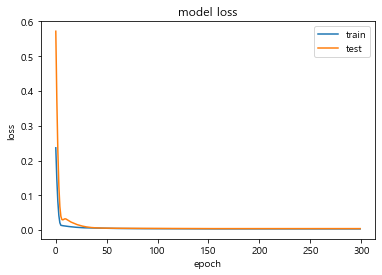

In [383]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

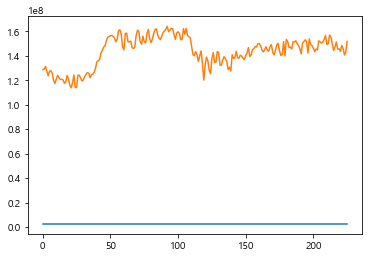

In [429]:
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

trainPredict = scaler.inverse_transform(trainPredict)
trainPredict

train_y = scaler.inverse_transform(train_y)
train_y

testPredict = scaler.inverse_transform(testPredict)
test_y = scaler.inverse_transform(test_y)

plt.plot(testPredict)
plt.plot(test_y)
plt.show()

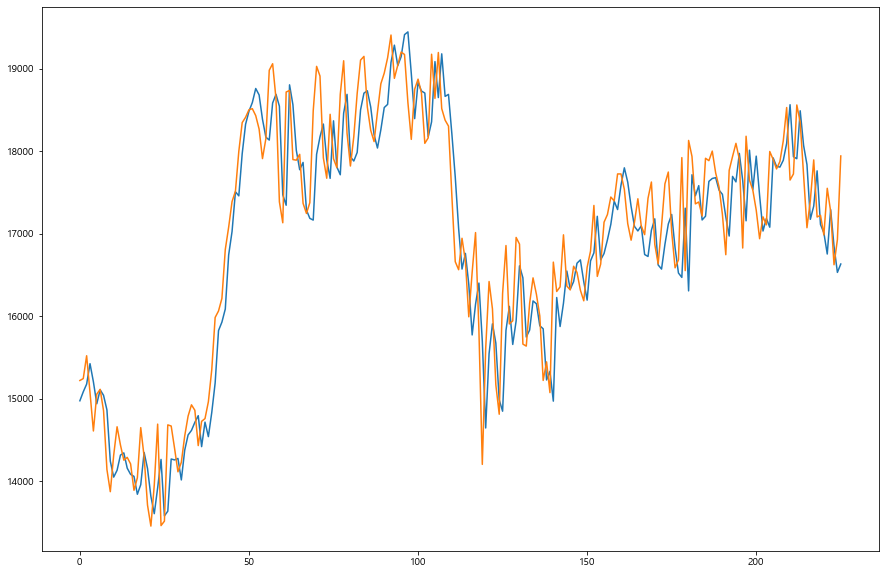

In [385]:
plt.figure(figsize=(15, 10))

plt.plot(testPredict)
plt.plot(test_y)
plt.show()

In [386]:
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(train_y,trainPredict))
print('TrainScore:%.df RMSE'%(trainScore))
testScore = math.sqrt(mean_squared_error(test_y,testPredict))
print('TestScore:%.df RMSE'%(testScore))

TrainScore:473f RMSE
TestScore:538f RMSE


In [387]:
print(trainScore)
print(testScore)

473.7172099370637
538.3717765559666


In [352]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(train_y,trainPredict[:,0]))
print(mean_absolute_percentage_error(test_y,testPredict[:,0]))

11.675888497205017
9.915870852151546


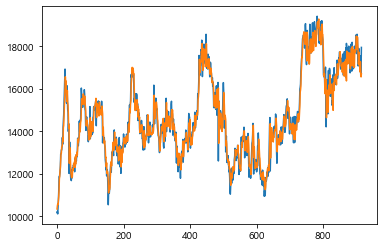

In [353]:
plt.plot(np.concatenate((train_y, test_y), axis=0))
plt.plot(np.concatenate((trainPredict, testPredict), axis=0))

### Modeling2
feature selection 안한 것

In [159]:
train_x = scaler.fit_transform(train[feature_names])
test_x = scaler.transform(test[feature_names])
train_y= scaler.fit_transform(pd.DataFrame(train['한우가격_미래값(y값)']))
test_y= scaler.transform(pd.DataFrame(test['한우가격_미래값(y값)']))

In [160]:
train_X = train_x.reshape(train_x.shape[0], 1, train_x.shape[1])
test_X = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(109, 1, 25) (109, 1) (165, 1, 25) (165, 1)


In [161]:
K.clear_session() 

# LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))  
model.add(Dense(1))

# 양방향 LSTM 
# from keras.layers import Bidirectional

# model = Sequential()
# model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
# model.add(Dense(1, activation="linear"))
# model.compile(loss='mse', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer='adam')

NameError: name 'K' is not defined

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
history = model.fit(train_X, train_y, epochs=500, batch_size=70, callbacks=[early_stop], validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
train_X.shape[2]

In [ ]:
# RNN
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, input_shape=(1, 24)))
model_RNN.add(Dense(1, activation="linear"))
model_RNN.compile(loss='mse', optimizer='adam')

#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
history = model.fit(train_X, train_y, epochs=100, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

trainPredict = scaler.inverse_transform(trainPredict)
trainPredict

train_y = scaler.inverse_transform(train_y)
train_y

testPredict = scaler.inverse_transform(testPredict)
test_y = scaler.inverse_transform(test_y)

plt.plot(test_y)
plt.plot(testPredict)

plt.show()

### MAPE

In [793]:
print(mean_absolute_percentage_error(train_y,trainPredict[:,0]))
print(mean_absolute_percentage_error(test_y,testPredict[:,0]))

14.848641318342818
3.560853123178257


### RMSE

In [794]:
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(train_y,trainPredict[:,0]))
print('TrainScore:%.df RMSE'%(trainScore))
testScore = math.sqrt(mean_squared_error(test_y,testPredict[:,0]))
print('TestScore:%.df RMSE'%(testScore))

TrainScore:534f RMSE
TestScore:666f RMSE


In [ ]:
warnings.filterwarnings(action='ignore')

scaler = preprocessing.MinMaxScaler() # Abscaler 써보기

tss = TimeSeriesSplit(n_splits=4)

accrs = []

for train_idx, test_idx in tss.split(data_week):
    train_d, test_d = data_week.iloc[train_idx], data_week.iloc[test_idx]
    
    pca = PCA(n_components=16,random_state=1)
    
    train_y = train_d['한우 평균경매 금액_주간평균']
    train_x = train_d[features]
    train_x = scaler.fit_transform(train_x)
    train_x = pca.fit_transform(train_x)
    
    test_y = test_d['한우 평균경매 금액_주간평균']
    test_x = test_d[features]
    test_x = scaler.transform(test_x)
    test_x = pca.transform(test_x)
    
    model = MLPRegressor(hidden_layer_sizes=[218, 32, 16], activation='identity', max_iter=500, alpha=0.05,
                        batch_size=16, random_state=1)
    model.fit(train_x, train_y)
    
    pred = model.predict(test_x)

    test = pd.concat([test_d[features],test_y],axis=1)
    test['pred'] = pred

    plt.figsize = (15,10)
    sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])
    plt.show()
    
    train_accr = model.score(train_x, train_y)
    test_accr = model.score(test_x, test_y)
    
    print('train_acc:',train_accr)
    print('test_acc:',test_accr)
    print(train_idx)
    print('-----Fold종료-----')

    accrs.append(test_accr)
    
print(np.average(accrs))